# Data Analysis

## Import Librarys and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# orders_qu.csv
url = "https://drive.google.com/file/d/143CzG5DriVSPMkaL1UP4k3Y80oS8fgbV/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_qu = pd.read_csv(path)

# orderlines_qu.csv
url = "https://drive.google.com/file/d/1yWO-mQfxQtnSZdCgdNlIEUrZSCW1HN5O/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_qu = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

# brands.csv
url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
brands = pd.read_csv(path)

In [3]:
# check names!
o = orders_qu.copy()
oli = orderlines_qu.copy()
p = products_cl.copy()
b = brands.copy()

In [4]:
# datatype from csv to_datetime
o["created_date"] = pd.to_datetime(o["created_date"])
oli["date"] = pd.to_datetime(oli["date"])

In [5]:
# Define Pandas display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)

## Create attributes

In [6]:
oli["unit_price_total"] = oli["unit_price"]* oli["product_quantity"]

In [7]:
order_price = oli.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [8]:
p["short"] = p["sku"].str[:3]

# Committed Business Questions

## How big are the offered discounts as a percentage of the product prices?

The average discount is 20.4 % (30,74 Euro), median is 16,67 % (14,72 Euro).

Negative discounts were not included in the calculation; 

Including negative discounts, the average is 19.15 % (28,26 Euro) median is 15,93 % (13,67 Euro).

## How do seasonality and special dates (Christmas, Black Friday) affect sales?

### About Discounts

In [9]:
poli = oli.merge(p, how="left", on="sku");
oli["YN_discount"] = poli.apply(
    lambda x: "discounted" if ((x.price - x.unit_price)/x.price) > 0.0
        else ("sold at higher price" if ((x.price - x.unit_price)/x.price) < 0.0
            else "sold at regular price"
             ),
    axis=1);

In [10]:
oli.sample(4)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,YN_discount
30650,1426422,433995,0,1,APP2072,986.59,2017-11-23 10:39:49,986.59,discounted
51505,1630132,518810,0,1,MAT0010,69.99,2018-02-28 12:14:08,69.99,sold at regular price
10912,1240761,352289,0,1,IFX0034,24.99,2017-05-03 14:48:58,24.99,sold at higher price
25308,1378352,412664,0,1,ALL0014,19.99,2017-10-15 13:56:03,19.99,discounted


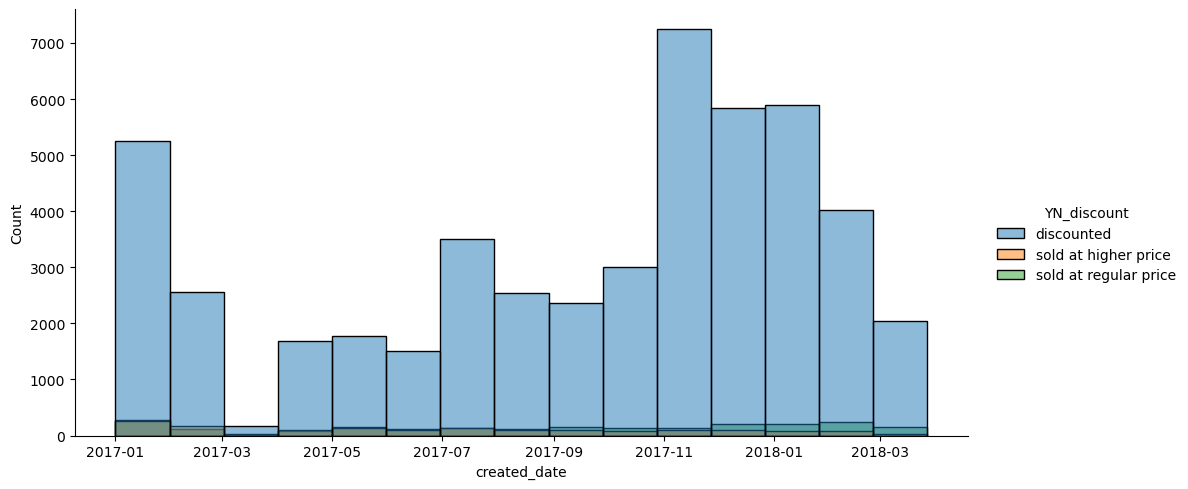

In [11]:
ooli = oli.merge(o, how="left", left_on="id_order", right_on="order_id");
sns.displot(data=ooli,
            x="created_date",
            hue="YN_discount",
            aspect=2,
            binwidth=30
           );

### Aggressive Discounts?

In [12]:
# poli = oli.merge(p, how="left", on="sku");

In [13]:
#discount graduation
discount_graduation = poli.apply(
    lambda x: "Mild Discounts" if ((x.price - x.unit_price)/x.price) <= 0.1
        else ("Medium Discounts" if ((x.price - x.unit_price)/x.price) <= 0.3
            else ("Aggressive Discounts")
        ),
    axis=1);

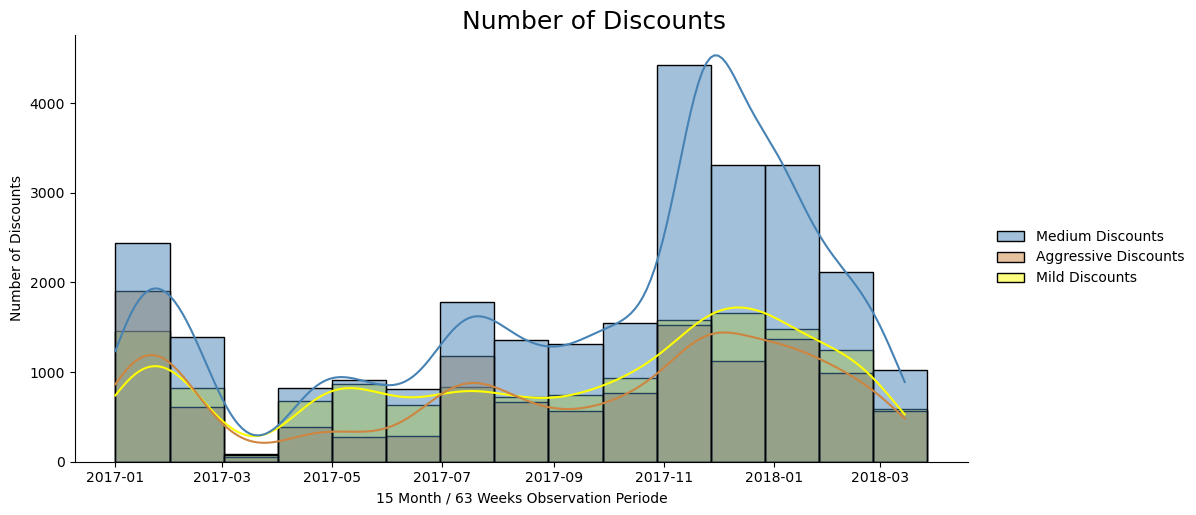

In [14]:
custom_palette = {'Mild Discounts': 'yellow', 'Medium Discounts': 'steelblue', 'Aggressive Discounts': 'peru'};
g = sns.displot(data=poli,
            x="date",
            hue=discount_graduation,
            aspect=2,
            binwidth=30,
            palette=custom_palette,
            kde=True
           );
g.set_axis_labels("15 Month / 63 Weeks Observation Periode", "Number of Discounts");
g.fig.suptitle("Number of Discounts", y=1.02, fontsize=18);
plt.show();

### Discounts - Revenues - Relation

In [15]:
# create discount (with created_date)
o["discount"] = poli["price"] - poli["unit_price"]

#group discount by order_id then sum
d_discounts = o.groupby(o["created_date"].dt.date)["discount"].sum().reset_index(name='discounts')
d_revenues = o.groupby(o["created_date"].dt.date)["total_paid"].sum().reset_index(name='revenues')

# merge both to daily on created_date
daily= d_revenues.merge(d_discounts, on="created_date")

#percentage column
daily["relation"] = (daily.revenues - daily.discounts)/daily.revenues 

# proceed with weekly
daily["created_date"] = pd.to_datetime(daily["created_date"], format='%Y-%m-%d')
weekly = daily.resample("W", on="created_date").sum().reset_index()

weekly.sample(4)

,created_date,revenues,discounts,relation
53,2018-01-07,229278.74,42380.66,5.75
29,2017-07-23,114271.91,16896.72,5.74
50,2017-12-17,259275.91,25910.59,6.31
16,2017-04-23,94537.01,14069.77,6.03


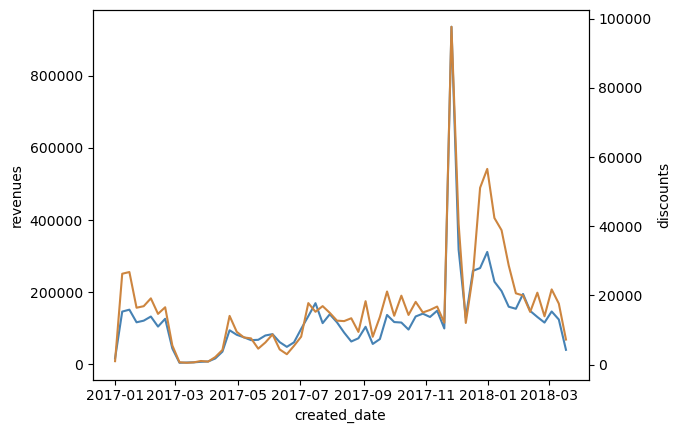

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots() 
ax2 = ax1.twinx() 

sns.lineplot(
    data=weekly,
    x="created_date",
    y="revenues",
    color="steelblue",
    ax=ax1
    )
sns.lineplot(
    data=weekly,
    x="created_date",
    y="discounts",
    color="peru",
    ax=ax2
    );

### Black Friday and Christmas

In [17]:
# sales_campaigns = df.loc[df["campaign"].isin(["Black Friday", "Christmas"])]

In [18]:
# blackfriday.value_counts()

#during sales periods
# number of sales

# vergleich2018: 35254 (10 weeks)
# vergleich2017: 30662+11116 = 41778 (10 weeks)
# blackfriday: 6162 ? (1 week)
# christmas: 22417+11116 = 33533 (6 weeks)

In [19]:
# pooli.loc[(pooli.campaign.str.contains("018")) & (pooli["piece_discount_percentage"] < 0)]["piece_discount_percentage"].count()

# during sales periods:
# number of sales with discount smaller/equal/larger than 0.0% (= overpriced, equalpriced, underpriced)
# vergleich2018: count=178,607,10250
# vergleich2017: count=428,386,7743
# blackfriday: count=34,27,6101
# christmas: count=128,329,8930

In [20]:
oli.YN_discount.value_counts()

#YN_discount
# discounted               49369
# sold at regular price     2255
# sold at higher price      1571
# Name: count, dtype: int64

YN_discount
discounted               49404
sold at regular price     2256
sold at higher price      1571
Name: count, dtype: int64

In [21]:
# christmas["piece_discount_percentage"].describe()
# count   9387.00
# mean      20.24
# std       16.69
# min      -39.83
# 25%        9.44
# 50%       16.67
# 75%       25.73
# max       86.46
# Name: piece_discount_percentage, dtype: float64

# blackfriday
# count   6162.00
# mean      23.25
# std       14.08
# min      -42.50
# 25%       14.00
# 50%       21.60
# 75%       29.60
# max       87.26
# Name: piece_discount_percentage, dtype: float64

# vergleich2017
# count   8453.00
# mean      23.30
# std       19.89
# min      -61.34
# 25%        9.73
# 50%       20.00
# 75%       33.34
# max       84.88
# Name: piece_discount_percentage, dtype: float64

# vergleich2018
# count   8788.00
# mean      22.13
# std       19.44
# min      -39.83
# 25%        8.57
# 50%       17.99
# 75%       27.79
# max       97.14
# Name: piece_discount_percentage, dtype: float64

**Plottings**

In [22]:
# plot v2017 and v2018
# ca. 70 Tage, bins = 70
# periods_v2017 = Series! (True/False?)

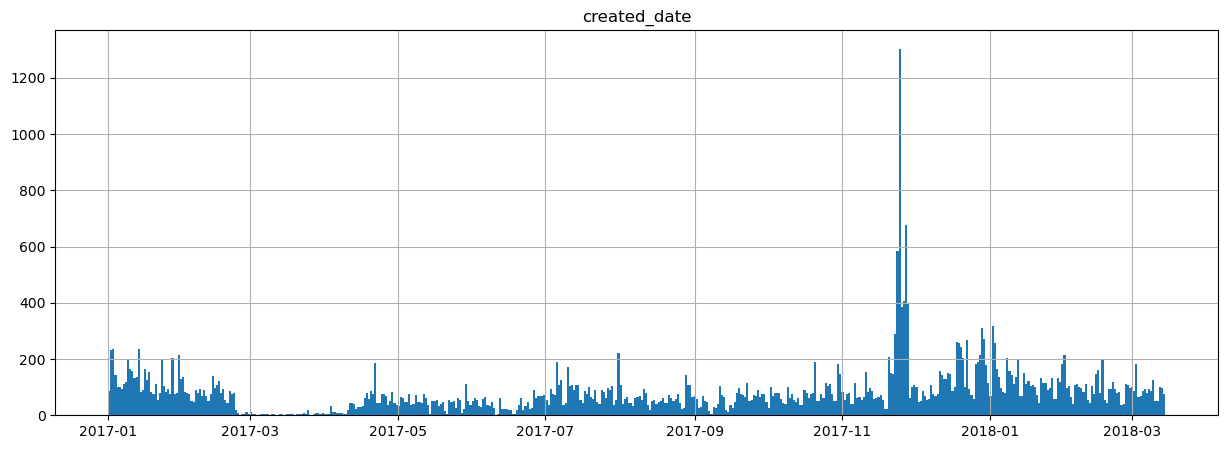

In [23]:
o["created_date"] = pd.to_datetime(o["created_date"])
o.hist(column="created_date", bins=500, figsize=(15,5));

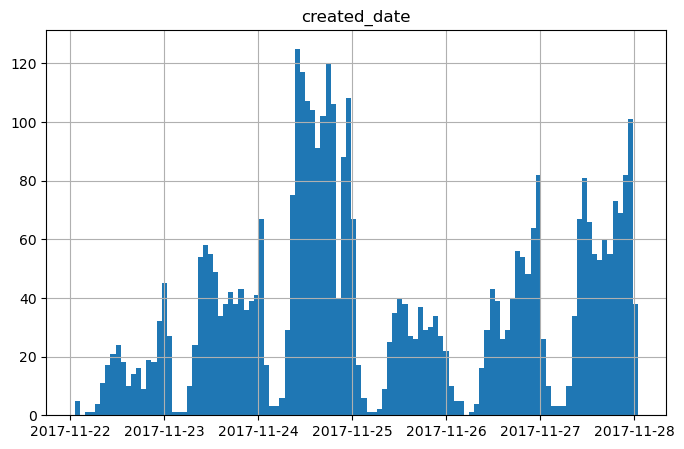

In [24]:
timeframe = o[(o["created_date"] >= "2017-11-22 01:00:00") & (o["created_date"] <= "2017-11-28 01:00:00")]
timeframe.hist(column="created_date", bins=110, figsize=(8,5));

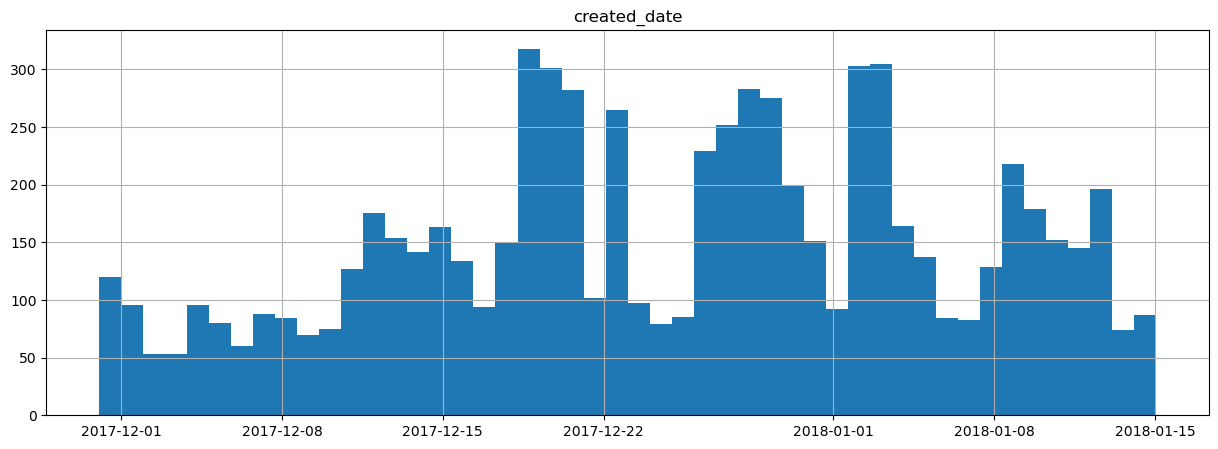

In [25]:
timeframe = o[(o["created_date"] >= "2017-11-30 01:00:00") & (o["created_date"] <= "2018-01-15 01:00:00")]
timeframe.hist(column="created_date", bins=48, figsize=(15,5));

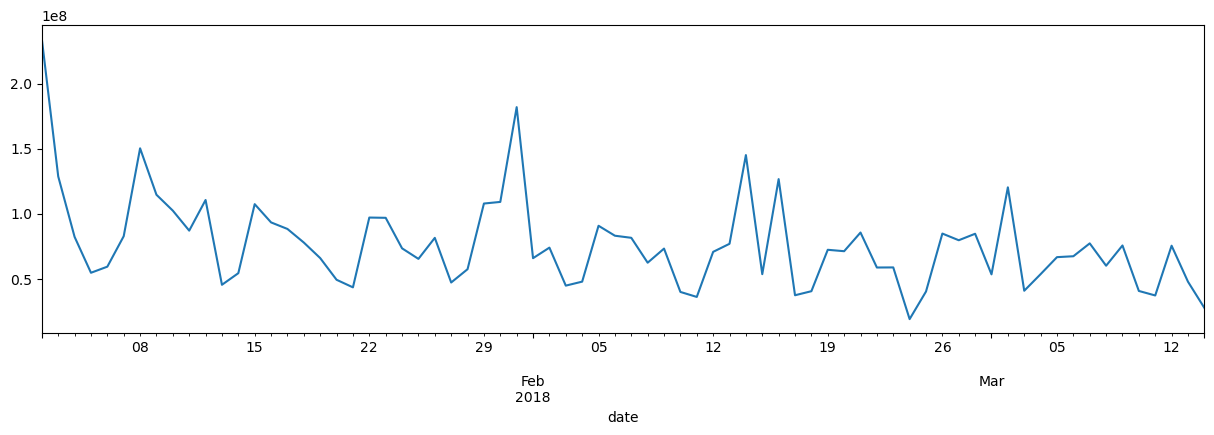

In [26]:
# Compare Jan till March 2018
# 2018
(
oli.loc[oli.date.between("2018-01-02 00:00:00", "2018-03-14 23:59:59")]
    .resample("D", on="date")
    ["id_order"].sum()
    .plot(figsize=(15, 4))
 );

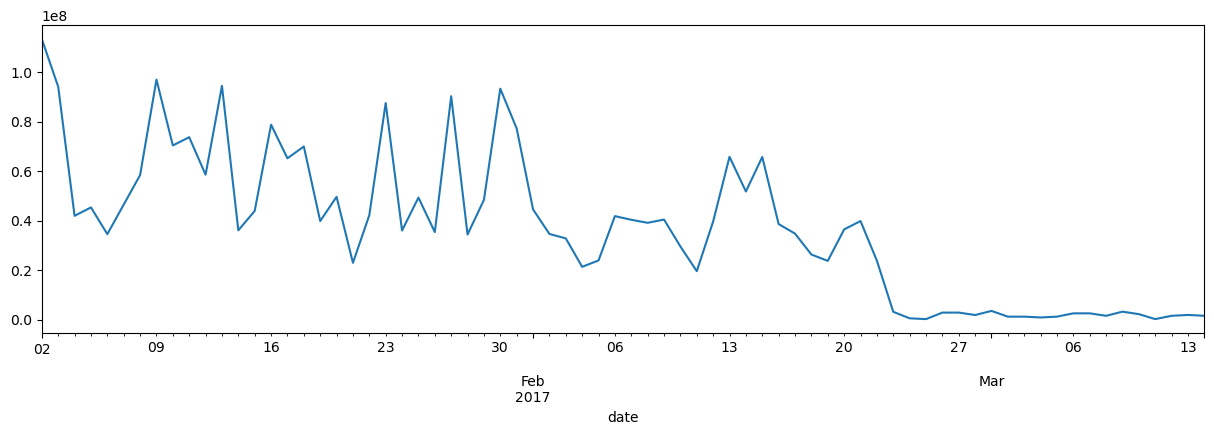

In [27]:
# Compare Jan till March 2017
# 2017:
(
oli.loc[oli.date.between("2017-01-02 00:00:00", "2017-03-14 23:59:59")]
    .resample("D", on="date")
    ["id_order"].sum()
    .plot(figsize=(15, 4))
 );

**Exkurs: plot the top 10 brands based on the amount of products sold**

In [28]:
# oli_with_brands_df = oli.merge(brands,
#                                 how="left",
#                                 left_on="short",
#                                 right_on="short")
# oli_with_brands_df.head(3)

In [29]:
# brands_10_most_sold_df = (
#                          oli_with_brands_df.groupby("long", as_index=False)
#                          ["product_quantity"].sum()
#                          .nlargest(10, "product_quantity")
#                          )
# brands_10_most_sold_df

## Resumée

What should Eniac’s strategy be concerning discounts?